In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-shark-attack/global-shark-attack.csv


Let's take a look at a dataset from [opendatasoft](https://public.opendatasoft.com/explore/dataset/global-shark-attack/information/?disjunctive.country&disjunctive.area&disjunctive.activity) containing information about reported shark attacks until 2022.

In [2]:
# Load the data into a pandas dataframe
df = pd.read_csv('../input/global-shark-attack/global-shark-attack.csv', sep=';')
df.head()

,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,...,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number,Case Number.1,original order
0,2023-05-21,2023.0,Unprovoked,USA,New Jersey,"Stone Harbor, Cape May County",Surfing,Maggie Drozdowski,F,15,...,N,15h00,NaN,"J. Marchand, GSAF",NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-05,2023.0,Unprovoked,MeXICO,Gulf of California,Tobari Bay,Diving with surface-supplied air,Manuel Nieblas López,M,53,...,Y,11h30,NaN,"El imparcial., 1/5/2023",NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-15,2022.0,Unprovoked,USA,South Carolina,"Myrtle Beach, Horry County",Standing,Karrren Sites,F,NaN,...,N,12h00,Blacktip shark,"C. Creswell, GSAF",2022.08.15.b-Sites.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2022.08.15.b,2022.08.15.b,6796.0
3,2021-08-07,2021.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,35.0,...,N,10h00,NaN,"J. Marchand, GSAF",2021.08.07.b-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2021..08.07.b,2021.08.07.b,6699.0
4,2021-07-11,2021.0,Provoked,BAHAMAS,NaN,NaN,Jackass Team's publicity stunt for Discovery C...,Sean McInerney,M,NaN,...,N,NaN,NaN,"Yahoo.com, 7/11/2021",2021.07.11.R-McInerney.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2021.07.11.R,2021.07.11.R,6683.0


In [3]:
df.shape[0]

6870

There are 6870 shark attacks in our DataFrame. Let's see how many entries are missing in each column

In [4]:
df.isna().sum()

Date                       303
Year                       132
Type                        19
Country                     51
Area                       480
Location                   565
Activity                   586
Name                       220
Sex                        571
Age                       2984
Injury                      36
Fatal (Y/N)                  0
Time                      3515
Species                   3108
Investigator or Source      21
pdf                         71
href formula                75
href                        74
Case Number                 72
Case Number.1               73
original order              71
dtype: int64

Each sample in the dataframe contains a binary column about whether the attack was fatal or not.  Let's visualize what percentage of attacks are fatal. However, there is a bit of data cleaning to do on the column first.

In [5]:
df = df.rename(columns={'Fatal (Y/N)': 'Fatal'})
df['Fatal'].value_counts()

N          4784
Y          1447
UNKNOWN     631
F             3
Nq            1
y             1
n             1
2017.0        1
Y x 2         1
Name: Fatal, dtype: int64

For the one-off entries, I looked at the samples to confirm if it was a 'Y' or a 'N'. In the case of 'UNKNOWN', these reports can not confirm shark involvement in the incident; so we will label them 'N'.

In [6]:
remap = {'F': 'Y',
        'UNKNOWN': 'N',
        'y': 'Y',
        'n': 'N',
        '2017.0': 'N',
        'Nq': 'N',
        'Y x 2': 'Y'}

df = df.replace({'Fatal': remap})

21 percent of shark attacks are fatal.


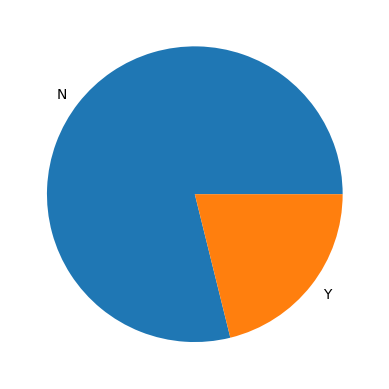

In [7]:
from matplotlib import pyplot as plt


pct_fatal = df['Fatal'].value_counts(normalize=True) * 100
pct_fatal_n, pct_fatal_y = pct_fatal['N'], pct_fatal['Y']

df.groupby('Fatal').size().plot(kind='pie')
print('%d percent of shark attacks are fatal.' % pct_fatal_y)

Next, let's check out the sex of those attacked by sharks. This time using plotly.

In [8]:
df = df.rename(columns={'Sex ': 'Sex'}) # fixing an erroneous space in the column name

fatal_attacks = df[df['Fatal'] == 'Y']
nonfatal_attacks = df[df['Fatal'] == 'N']

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'pie'}, {'type': 'pie'}]])

fig.add_trace(go.Pie(
             values = nonfatal_attacks.groupby('Sex').size(),
             labels = ['Female', 'Male'],
             title='Non-fatal attack victims by sex'),
             row=1, col=1)

fig.add_trace(go.Pie(
             values = fatal_attacks.groupby('Sex').size(),
             labels = ['Female', 'Male'],
             title='Fatal attack victims by sex'),
             row=1, col=2)

Looks like mostly men get attacked by sharks! Also there is a not a significant difference in sex between fatal and non-fatal attacks

Next, let's investigate when shark attacks occur most. First we'll look at the month of the year.

/tmp/ipykernel_20/2773725497.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Month'>

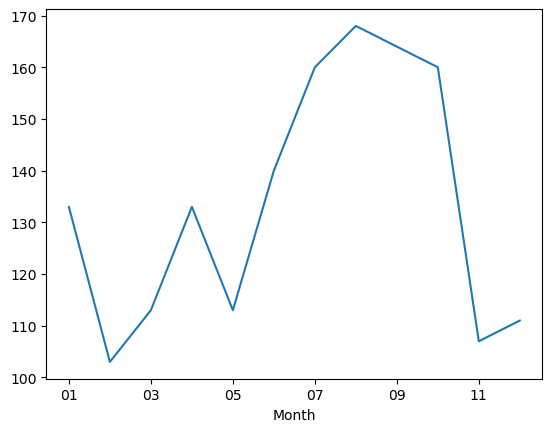

In [9]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

#A lot of older enties have Jan 1st as the date by default. We will drop these to not skew the month visualization.
df_months = df
df_months.dropna(inplace=True)
df_months = df_months[df_months['Date'].dt.strftime('%m%d') != '0101']
df_months.head()

df_months['Month'] = df_months['Date'].dt.strftime('%m')
month_counts = df_months.groupby('Month')['Fatal'].count()
month_counts.plot()

So the Summer months see the greatest number of shark attacks. There is also interesting upticks in January and April. Perhaps those months are when people like to take vacation to the beach.

Now let's look at the number of shark attacks per year. You can see that attacks greatly dropped off when people were stuck in their houses during the global pandemic in 2020-2021.

<Axes: xlabel='Year'>

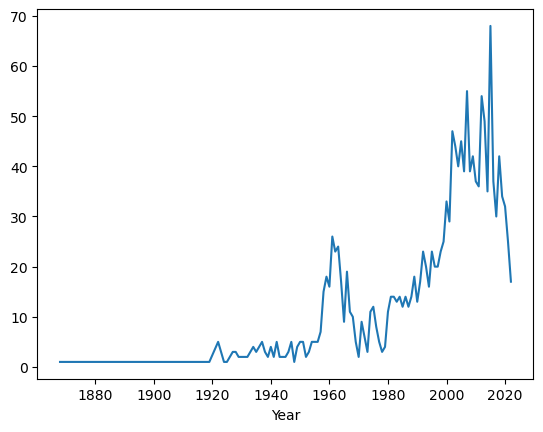

In [10]:
df.groupby('Year')['Fatal'].count().plot()

The next thing area to analyze is the age of the shark attack victims. We'll use a histogram with plotly to check this out. First we have to clean up the age column a bit.

In [11]:
df['Age'].unique()

array(['14.0', '29.0', '16.0', '58.0', '42.0', '55.0', '61.0', '26.0',
       '71.0', '46.0', '18', '44', '20s', '48', '30', '28', '21', '70',
       '37', '32', '16', '43', '63', '59', '30s', '47', '15.0', '39.0',
       '23.0', '23', '52.0', '5.0', '50.0', '24.0', '40.0', '41.0',
       '17.0', '37.0', '27.0', '28.0', '20', '19.0', '53.0', '49', '11.0',
       '13.0', '18.0', '21.0', '10.0', '68', '12', '39', '35', '10', '51',
       '31', '17', '54', '13', '40', '43.0', '31.0', '22.0', '14', '38.0',
       '34', '26', '25.0', '12.0', '20.0', '15', '60.0', '33.0', '48.0',
       '38', '36', '42', '50', '22', '34.0', '45', '25', '49.0',
       '13 or 18', '59.0', '51.0', '64.0', '9', '60', '55', '58', '29',
       '8', '44.0', '6½', '9.0', '30.0', '9 & 60', '32.0', '40s', '56',
       '24', '54.0', '70.0', '57.0', '74.0', '71', '46', '62', '27', '61',
       '19', '7', '52', '36.0', '35.0', '69.0', '8.0', '30 or 36', 'Teen',
       '6', '33', '30 & 32', '9 or 10', '6.0', '47.0', '21, 

In [12]:
# create a new df and drop the samples where we can not easily convert the age column to a numeric vale (i.e. '>50' or '45 and 15')
age_df = df
age_df['Age'] = pd.to_numeric(age_df['Age'], errors = 'coerce')
age_df = age_df.dropna(subset=['Age'])
age_df['Age'] = age_df['Age'].astype('int')

/tmp/ipykernel_20/2031855120.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
import plotly.express as px

fig = px.histogram(age_df, x='Age', nbins=10)
fig.update_layout(bargap=0.1)
fig.show()

We can see that people in their 20s are the most common shark attack victims, followed by teenagers.

Our last graph is going to be a bar graph looking at the activity the victim was participating in before the attack (i.e. surfing, swimming...)

In [14]:
df['Activity'].value_counts()

Surfing                                                             464
Swimming                                                            251
Spearfishing                                                        115
Wading                                                               56
Fishing                                                              55
                                                                   ... 
Dived overboard to check propeller of US Navy motor torpedo boat      1
Fell overboard, hanging onto lifebuoy                                 1
Feeding sharks & stingrays                                            1
Unknown                                                               1
Swimming after a tennis ball                                          1
Name: Activity, Length: 339, dtype: int64

In [15]:
# To make this simpler we will drop any sample with an 'Activity' that occurs less than four times

is_multi = df['Activity'].value_counts() > 3
activity_df = df[df['Activity'].isin(is_multi[is_multi].index)]
activity_df['Activity'].value_counts()

Surfing                           464
Swimming                          251
Spearfishing                      115
Wading                             56
Fishing                            55
Snorkeling                         43
Body boarding                      36
Standing                           36
Scuba diving                       24
Diving                             22
Body surfing                       19
Kayaking                           19
Boogie boarding                    18
Treading water                     18
Free diving                        12
Surf skiing                         8
Walking                             7
Windsurfing                         7
Free diving for abalone             7
Paddle boarding                     7
Bathing                             6
Surf-skiing                         6
Floating                            6
Surfing (sitting on his board)      5
Stand-Up Paddleboarding             5
Playing                             5
Diving for a

In [16]:
# To finish up this data cleaning we will rename some of lesser-occuring activity names to align with the category they actually belong to

remap = {'Boogie Boarding': 'Boogie boarding',
        'Body Boarding': 'Boogie boarding',
        'Body boarding': 'Boogie boarding',
        'Body surfing': 'Boogie boarding',
        'Diving for abalone': 'Diving',
        'Playing': 'Wading',
        'Stand-Up Paddleboarding': 'Paddle boarding',
        'Surfing (sitting on his board)': 'Surfing',
        'Bathing': 'Wading',
        'Free diving for abalone': 'Diving',
        'Free diving': 'Diving',
        'Walking': 'Wading',
        'Surf skiing': 'Kayaking',
        'Surf-skiing':'Paddleboarding',
        'Standing': 'Wading',
        'Bathing': 'Wading',
        'Floating': 'Swimming',
        'Treading water': 'Swimming',
        'diving': 'Diving',
        'Paddleboarding': 'Paddle boarding'}

activity_df = activity_df.replace({'Activity': remap})

In [17]:
fig = px.histogram(activity_df, x='Activity')
fig.update_layout(bargap=0.1)
fig.show()

Next, we will take the liberty of combining the groups even further into 'Surfing', 'Swimming', 'Diving', and 'Other' and see how attacks during these activities have changed over time

In [18]:
remap = {'Wading': 'Swimming',
        'Fishing': 'Other',
        'Spearfishing': 'Diving',
        'Paddle boarding': 'Other',
        'Kayaking': 'Other',
        'Boogie boarding': 'Surfing',
        'Snorkeling': 'Diving',
        'Scuba diving': 'Diving',
        'Wading': 'Swimming',
        'Windsurfing': 'Other'}

activity_df = activity_df.replace({'Activity': remap})

In [19]:
activity_df['Year'] = activity_df['Year'].astype('int')

activity_pv = activity_df.pivot_table(values='Date', index='Year',  columns='Activity', aggfunc='count')
activity_pv.index

#drop years less than 1920 because there really is not much data there to look at
activity_pv= activity_pv[activity_pv.index > 1960] 

In [20]:
fig = px.line(activity_pv, x = activity_pv.index, y = ['Diving', 'Other', 'Surfing', 'Swimming'])
fig.show()

You can really see the popularity of surfing increasein the late 80s to 2000s. Also interesting to look at how swimming sharply increased in the early 2000s, while diving has remained pretty steady for the whole time period.

Lastly, lets plot these shark attacks on a world map to see where attacks occur the most

In [21]:
from geopy.geocoders import Nominatim
import geopandas as gpd

geolocator = Nominatim(user_agent="kaggle")
def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None
    
# Geocode df based on 'Location'
geo_df = df
geo_df[['Lat', 'Long']] = geo_df.apply(lambda x: my_geocoder({x['Location'] + ', ' + x['Area'] + ', ' + x['Country']}), axis=1)
geo_df.head()


print(print('{}% of attack locations were succesfully geocoded'.format(
    (1 - sum(np.isnan(geo_df['Lat'])) / len(geo_df)) * 100)))

ValueError: Columns must be same length as key

In [ ]:
# Drop samples that were unsuccesfully geocoded
geo_df = geo_df.loc[~np.isnan(geo_df['Lat'])]
geo_df = gpd.GeoDataFrame(
    geo_df, geometry=gpd.points_from_xy(geo_df.Long, geo_df.Lat))
geo_df.crs = {'init': 'epsg:4326'}

In [ ]:
# Create a map of geo_df
import folium
from folium import Marker

m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in geo_df.iterrows():
    Marker([row['Lat'], row['Long']], popup=row['Location']).add_to(m)

# Display the map
m

The density of markers can tell us where attacks most commonly occur. Also, it looks like only 57% our locations were able to geocode.